In [1]:
#CNN with Glove embeddings
#load data
import os
mypath="C:/Users/USER/eRisk2017/2017/"
os.chdir( mypath )

In [2]:
import pandas as pd
import numpy as np

df_train=pd.read_csv('train_Depression_all_chunks_nosteem.csv')
df_train=df_train.replace(np.nan, '', regex=True)
df_test=pd.read_csv('test_Depression_all_chunks_nosteem.csv')
df_test=df_test.replace(np.nan, '', regex=True)

C:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
def generate_data(df, nchunks=1):
    # Extract the first chunk of data
    data = df['Chunk_1']
    
    # Rename the column to 'x' (although this line has no effect as it doesn't modify the original DataFrame)
#     data.rename(columns={'Chunk_1': 'x'})
    
    # If nchunks is less than or equal to 1, do nothing
    if nchunks <= 1:
        pass
    else:
        # Iterate over the remaining chunks and concatenate them with the first chunk
        for i in range(2, nchunks):
            chunk = 'Chunk_' + str(i)
            data += df[chunk]
    
    # Return the values of the concatenated data
    return data.values

In [4]:
# Glove
# !wget -P /root/input/ -c "http://nlp.stanford.edu/data/glove.6B.zip"
#downloaded from https://nlp.stanford.edu/data/glove.6B.zip

In [5]:
from zipfile import ZipFile 

zip=ZipFile('C:/Users/USER/glove.6B.zip', 'r')

zip.extract('glove.6B.100d.txt',path="C:/Users/USER/")
del zip

In [6]:
# Glove embbeding

embeddings_glove = {}
f = open('C:/Users/USER/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_glove[word] = coefs
f.close()

In [7]:
# Create text sequences and embed layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
# Create term count (BoW)
def create_tokenizer(corpus_train):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus_train)
    return tokenizer

# Calculate the maximum document length (define the sequence dimension)
def max_length(corpus_train):
    return max([len(s.split()) for s in corpus_train])

# Encode a list of lines (create the word sequence)
def encode_text(tokenizer, lines, length):
    # Integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # Pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded


In [9]:
#Weight matrix of embeddings

In [10]:
def embeddingLayer(tokenizer, dictembedding):
  dim_emb = len(list(dictembedding.values())[0])

  # Create a dictionary where the keys are word indices
  vocabulary_inv = {v: k for k, v in tokenizer.word_index.items()}
  vocabulary_inv[0] = "<PAD/>"

  # Create embeddings for the vocabulary
  embedding_weights = {key: dictembedding[word] if word in dictembedding else
                            np.random.uniform(-0.25, 0.25, 100)
                      for key, word in vocabulary_inv.items()}

  # Convert the layer to a np.array
  return np.array([embedding_weights[i] for i in range(len(embedding_weights))])


In [11]:
#Define Model
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.layers import Activation
from keras.layers import GlobalMaxPooling1D 
from keras.utils import plot_model
from pickle import load
from sklearn.utils import class_weight
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [12]:
#metrics:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [13]:
# define the model
def define_model(length, weights,seed=1013,num_filters=32):
  
  #model parameters
  vocab_size,embed_dim = weights.shape 
    
  #seed
  np.random.seed(seed)
  
  ### DEFINE LAYERS
  
  #### Process layers
  inputs1 = Input(shape=(length,))
  embedding1 = Embedding(vocab_size, embed_dim, weights=[weights], trainable=False)(inputs1)
  conv1 = Conv1D(num_filters, 4, activation='relu', padding='same')(embedding1)
  maxpool1 = MaxPooling1D(2)(conv1)
  conv2 = Conv1D(num_filters, 4, activation='relu', padding='same')(maxpool1)
  Gpool1=GlobalMaxPooling1D()(conv2)
  drop1 = Dropout(0.5)(Gpool1)
  
  ### prediction layers
  dense1 = Dense(32, activation='relu')(drop1)
  outputs = Dense(1, activation='sigmoid')(dense1)
  model = Model(inputs=inputs1, outputs=outputs)
  
  # compile
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])
  
  # summarize
  #print(model.summary())
  #plot_model(model, show_shapes=True, to_file=DATA_PATH+'onechannel.png')
  return model

In [19]:
def CNN_emb(train, test, dictembedding, nChunks=1, epochs=5, batch_size=16, maxlengthseq=None):
  
  # Load data
  x_train = generate_data(train, nChunks)
  y_train = train['Depress'].values
  x_test = generate_data(test, nChunks)
  y_test = test['Depress'].values

  # Initialize tokenizer
  tokenizer = create_tokenizer(x_train)

  # Calculate max document length
  if maxlengthseq is None:
    length = max_length(x_train) + 1
  else:
    length = maxlengthseq
  
  # Calculate vocabulary size
  vocab_size = len(tokenizer.word_index) + 1
  
  print('Chunks: {}'.format(nChunks))
  print('Max document length: %d' % length)
  print('Vocabulary size: %d' % vocab_size)

  # Create embedding layer
  weights = embeddingLayer(tokenizer, dictembedding)
  
  # Encode data train
  trainX = encode_text(tokenizer, x_train, length)

  # Encode data test
  testX = encode_text(tokenizer, x_test, length)
  
  # Compute class weights for unbalanced data
    
  class_weights =  dict(enumerate(class_weight.compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)))
# class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)
# Compute class weights for unbalanced data
# class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)))
#   class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)

  # Compile model
  model = define_model(length, weights)
  # Fit model
  history = model.fit(trainX, y_train, epochs=epochs, batch_size=batch_size, class_weight=class_weights, verbose=1)
  # Evaluate the model
  loss, accuracy, f1_score, precision, recall = model.evaluate(testX, y_test, verbose=0)
  return [nChunks, accuracy, f1_score, precision, recall]


In [15]:
#Results
import time
Chunks=[i for i in range(1,11)]
CNNGlove_metrics=np.empty((0,5),float)
Chunks

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [20]:
for chunk in Chunks:
    tic = time.time()
    metrics = CNN_emb(df_train, df_test, dictembedding=embeddings_glove, nChunks=chunk, epochs=80, batch_size=8, maxlengthseq=30000)
    CNNGlove_metrics = np.vstack([CNNGlove_metrics, metrics])
    print('Chunks: {} \t Processing Time (secs): {}'.format(chunk, time.time() - tic))
    print('Test: \t Accuracy={}, \n\t F1 score={}, \n\t Precision={}, \n\t Recall={}'.format(metrics[1], metrics[2], metrics[3], metrics[4]))
    print('#####################################################################')
    print('\n\n')


Chunks: 1
Max document length: 30000
Vocabulary size: 32567
Epoch 1/80
61/61 [==============================] - 20s 309ms/step - loss: 0.7422 - accuracy: 0.5226 - f1_m: 0.2158 - precision_m: 0.2026 - recall_m: 0.4030
Epoch 2/80
61/61 [==============================] - 19s 311ms/step - loss: 0.6980 - accuracy: 0.5679 - f1_m: 0.2584 - precision_m: 0.2039 - recall_m: 0.4399
Epoch 3/80
61/61 [==============================] - 19s 314ms/step - loss: 0.6588 - accuracy: 0.6049 - f1_m: 0.3055 - precision_m: 0.2470 - recall_m: 0.4740
Epoch 4/80
61/61 [==============================] - 19s 308ms/step - loss: 0.6269 - accuracy: 0.6399 - f1_m: 0.3483 - precision_m: 0.2655 - recall_m: 0.5915
Epoch 5/80
61/61 [==============================] - 19s 307ms/step - loss: 0.5628 - accuracy: 0.7202 - f1_m: 0.4260 - precision_m: 0.3713 - recall_m: 0.5738
Epoch 6/80
61/61 [==============================] - 19s 312ms/step - loss: 0.5519 - accuracy: 0.7366 - f1_m: 0.4225 - precision_m: 0.3782 - recall_m: 0.580

In [21]:
CNNGlove=pd.DataFrame(CNNGlove_metrics, columns=['Chunks','Acc','F1Score','Precission','Recall'])
CNNGlove

,Chunks,Acc,F1Score,Precission,Recall
0,1.0,0.845387,0.026565,0.128205,0.014904
1,2.0,0.867830,0.037161,0.153846,0.021154
2,3.0,0.605985,0.120108,0.132479,0.110096
3,4.0,0.850374,0.085470,0.138462,0.062019
4,5.0,0.810474,0.097436,0.146154,0.073077
5,6.0,0.847880,0.063230,0.145299,0.042788
6,7.0,0.887781,0.087101,0.153846,0.061058
7,8.0,0.870324,0.090779,0.153846,0.064423
8,9.0,0.892768,0.087912,0.153846,0.062500
9,10.0,0.835411,0.102767,0.147929,0.079808


C:\Users\USER\AppData\Local\Temp\ipykernel_21804\2623171691.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


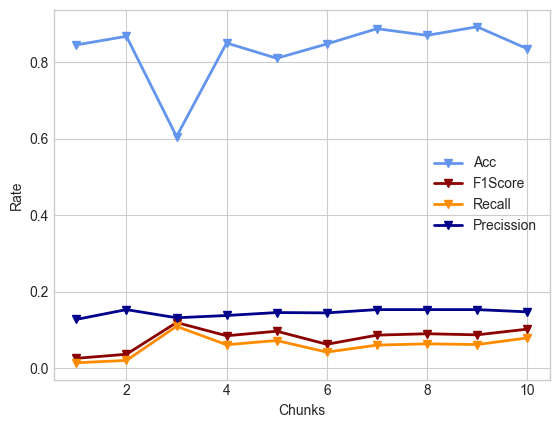

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# multiple line plot
plt.plot( 'Chunks', 'Acc', data=CNNGlove, marker='v', color='cornflowerblue', linewidth=2)
plt.plot( 'Chunks', 'F1Score', data=CNNGlove, marker='v', color='darkred', linewidth=2)
plt.plot( 'Chunks', 'Recall', data=CNNGlove, marker='v', color='darkorange', linewidth=2)
plt.plot( 'Chunks', 'Precission', data=CNNGlove, marker='v', color='darkblue', linewidth=2)
plt.xlabel("Chunks")
plt.ylabel("Rate")
plt.legend()